# NodeNorm Log Analysis

As of [PR #312](https://github.com/TranslatorSRI/NodeNormalization/pull/312), NodeNorm produces logs in the format:

```
2025-06-18T03:26:30-04:00	2025-06-18 07:26:30,635 | INFO | normalizer:get_normalized_nodes | Normalized 1 nodes in 1.21 ms with arguments (curies=['UMLS:C0132098'], conflate_gene_protein=True, conflate_chemical_drug=True, include_descriptions=False, include_individual_types=True)
```

This Jupyter Notebook is intended to be used in analysing these logs.

## Install prerequisites

In [28]:
%pip install pandas matplotlib

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 35.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.1 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.8 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [matplotlib]1 [matplotlib]
Note: you may need to restart the kernel to u

## Loading files

These files can be checked into the repository into the `logs/` subdirectory.

In [2]:
logfile = "logs/nodenorm-renci-logs-2025jun18.txt"

We can use Python dataclasses to load the important information from the logfile.

In [25]:
from dataclasses import dataclass, field
from datetime import datetime
import logging
import re
import ast

logging.basicConfig(level=logging.INFO)

@dataclass
class LogEntry:
    time: datetime
    curies: list[str]
    curie_count: int
    time_taken_ms: float
    time_taken_per_curie_ms: float
    arguments: dict[str, str]
    node: str = ""

def convert_log_line_into_entry(line: str) -> LogEntry:    
    # Depending on where the log file comes from, it might start with one of two types of timestamps:
    # - ISO 8601 date (e.g. "2007-04-05T12:30−02:00"), which will be separated from the rest of the log line with a tab character.
    # - Python log format date (e.g. "2025-06-12 13:01:49,319"), which should always be in UTC.

    # Entry variables.
    log_time = None
    curies = []
    curie_count = -1
    time_taken_ms = -1.0
    arguments = {}

    # Parse the datetime stamp.
    iso8601date_match = re.match(r'^(\d{4}-\d{2}-\d{2}(?:[T ]\d{2}:\d{2}(?::\d{2}(?:\.\d+)?(?:Z|[+-]\d{2}:\d{2})?)?)?)\t', line)
    if iso8601date_match:
        log_time = datetime.fromisoformat(iso8601date_match.group(1))
    else:
        # TODO raise exception
        logging.error(f"Could not identify the datetime for the line: {line}")

    # Parse the log text.
    log_text_match = re.search(r'\| INFO \| normalizer:get_normalized_nodes \| Normalized (\d+) nodes in ([\d\.]+) ms with arguments \((.*)\)', line)
    if not log_text_match:
        raise ValueError(f"Could not find NodeNorm log-line: {line}")
    curie_count = int(log_text_match.group(1))
    time_taken_ms = float(log_text_match.group(2))
    argument_text = log_text_match.group(3)

    # To parse the argument_text, we can turn it into a function call and use Python's ast module to parse it.
    argument_fn_call = f'arguments({argument_text})'
    tree = ast.parse(argument_fn_call, mode="eval")
    call_node = tree.body
    for kw in call_node.keywords:
        arguments[kw.arg] = ast.literal_eval(kw.value)

    # Some assertions.
    if 'curies' not in arguments:
        raise ValueError(f'No CURIEs found in arguments {argument_text} on line {line}, which was parsed into: {arguments}')
    curies = arguments['curies']
    if len(curies) != curie_count:
        raise ValueError(f'Found {len(curies)} CURIEs in arguments but expected {curie_count} CURIEs: {curies}')
    if len(curies) < 1:
        raise ValueError(f'Found no CURIEs in line: {line}')
    
    # Emit the LogEntry.
    return LogEntry(
        time=log_time,
        curies=curies,
        curie_count=curie_count,
        time_taken_ms=time_taken_ms,
        time_taken_per_curie_ms=time_taken_ms/curie_count,
        arguments=arguments
    )

logs = []
with open(logfile, 'r') as logf:
    for line in logf:
        # We're only interested in log-lines -- these will all contain `normalizer:get_normalized_nodes`
        if "normalizer:get_normalized_nodes" not in line:
            continue
        
        logs.append(convert_log_line_into_entry(line))

In [26]:
logs

[LogEntry(time=datetime.datetime(2025, 6, 18, 14, 23, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))), curies=['PMID:17553787'], curie_count=1, time_taken_ms=2.1, time_taken_per_curie_ms=2.1, arguments={'curies': ['PMID:17553787'], 'conflate_gene_protein': True, 'conflate_chemical_drug': False, 'include_descriptions': False, 'include_individual_types': False}, node=''),
 LogEntry(time=datetime.datetime(2025, 6, 18, 14, 23, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))), curies=['GO:0008285'], curie_count=1, time_taken_ms=1.5, time_taken_per_curie_ms=1.5, arguments={'curies': ['GO:0008285'], 'conflate_gene_protein': True, 'conflate_chemical_drug': False, 'include_descriptions': False, 'include_individual_types': False}, node=''),
 LogEntry(time=datetime.datetime(2025, 6, 18, 14, 23, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))), curies=['PMID:16943770'], curie_count=1, time_taken_ms=3.21, time_taken_per_cur

## Visualizing the logs

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict

# Assume `records` is your list of dataclass instances
# Convert to DataFrame
df = pd.DataFrame([asdict(r) for r in logs])
df['time'] = pd.to_datetime(df['time'])
df['throughput_cps'] = df['curie_count'] / df['time_taken_ms'] * 1000

df.head()


,time,curies,curie_count,time_taken_ms,time_taken_per_curie_ms,arguments,node,throughput_cps
0,2025-06-18 14:23:48-04:00,[PMID:17553787],1,2.10,2.10,"{'curies': ['PMID:17553787'], 'conflate_gene_p...",,476.190476
1,2025-06-18 14:23:48-04:00,[GO:0008285],1,1.50,1.50,"{'curies': ['GO:0008285'], 'conflate_gene_prot...",,666.666667
2,2025-06-18 14:23:48-04:00,[PMID:16943770],1,3.21,3.21,"{'curies': ['PMID:16943770'], 'conflate_gene_p...",,311.526480
3,2025-06-18 14:23:48-04:00,[PMID:17553787],1,1.97,1.97,"{'curies': ['PMID:17553787'], 'conflate_gene_p...",,507.614213
4,2025-06-18 14:23:48-04:00,[KEGG:hsa05200],1,2.13,2.13,"{'curies': ['KEGG:hsa05200'], 'conflate_gene_p...",,469.483568


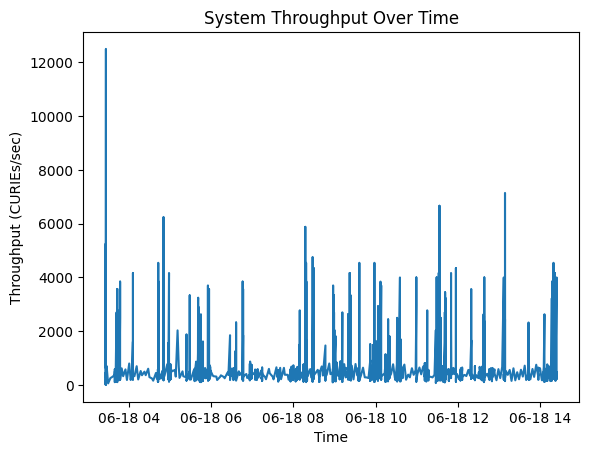

In [32]:
# 1. Time series of throughput (curies per second)
plt.figure()
plt.plot(df['time'], df['throughput_cps'])
plt.xlabel("Time")
plt.ylabel("Throughput (CURIEs/sec)")
plt.title("System Throughput Over Time")
plt.show()

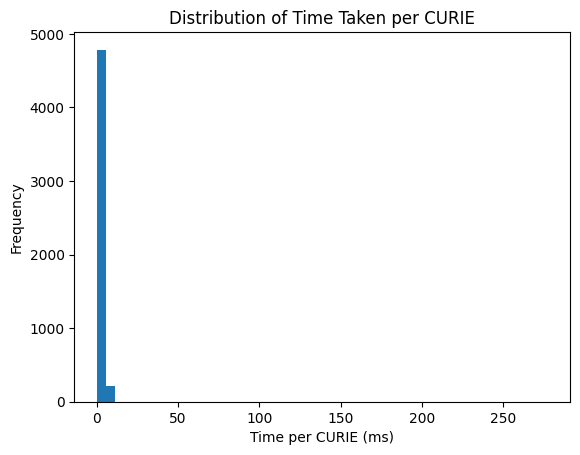

In [33]:
# 2. Histogram of time per CURIE
plt.figure()
plt.hist(df['time_taken_per_curie_ms'], bins=50)
plt.xlabel("Time per CURIE (ms)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Taken per CURIE")
plt.show()

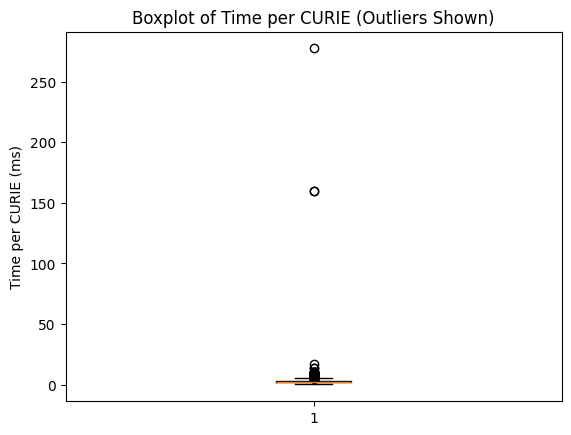

In [34]:
# 3. Boxplot to highlight outliers in time per CURIE
plt.figure()
plt.boxplot(df['time_taken_per_curie_ms'])
plt.ylabel("Time per CURIE (ms)")
plt.title("Boxplot of Time per CURIE (Outliers Shown)")
plt.show()